In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import numpy.fft as fp

import matplotlib.image as mpimg
from PIL import Image
import scipy

from skimage.io import imread
import scipy.fftpack as fftpack

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
IMG1_FILE = './given-images/Image1.png'
IMG2_FILE = './given-images/Image4.png'

In [3]:
img1 = cv2.imread(IMG1_FILE)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread(IMG2_FILE)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [5]:
def normalize(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

#  implement separable convolution routines

In [16]:

def generate_2D_filter_from_separable_filters(filter_1D):
    return np.outer(filter_1D, filter_1D)

laplacian_1D_kernel = np.asarray([1, -2, 1])
generate_2D_filter_from_separable_filters(laplacian_1D_kernel)

array([[ 1, -2,  1],
       [-2,  4, -2],
       [ 1, -2,  1]])

In [12]:
test_log_2D = LoGKernel((3, 3), 1.0)
test_log_2D

array([[ 0.        , -0.24197072,  0.        ],
       [-0.24197072, -0.79788456, -0.24197072],
       [ 0.        , -0.24197072,  0.        ]])

In [18]:
def l_o_g(x, y, sigma):
    # Formatted this way for readability
    nom = ( (y**2)+(x**2)-2*(sigma**2) )
    denom = ( (2*math.pi*(sigma**6) ))
    expo = math.exp( -((x**2)+(y**2))/(2*(sigma**2)) )
    return nom*expo/denom

mask = np.zeros((3, 1))
for i in range(3):
    mask[i, 0] = l_o_g(i, 0, 1.0)
    
output_mask = generate_2D_filter_from_separable_filters(mask.transpose())
output_mask

array([[ 0.10132118,  0.0307272 , -0.01371233],
       [ 0.0307272 ,  0.0093185 , -0.00415847],
       [-0.01371233, -0.00415847,  0.00185576]])

# Q1. Computes the gradient magnitude of an image

In [4]:
def image_2D_convolve(image, kernel):
    width = image.shape[1]
    height = image.shape[0]
    w_range = int(math.floor(kernel.shape[0]/2))

    result_image = np.zeros((height, width))

    for i in range(w_range, width-w_range):
        for j in range(w_range, height-w_range):
            for k in range(-w_range, w_range+1):
                for h in range(-w_range, w_range+1):
                    result_image[j, i] += kernel[w_range+h, w_range+k] * image[j+h, i+k]
    return result_image


def Gradient_Magnitude(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # apply sobel filters for x- & y- directions
    x_sobel_kernel = np.asarray([[ -1,  0, 1],
                                     [ -2,  0, 2],
                                     [ -1,  1, 1]])
    
    y_sobel_kernel = np.asarray( [[ 1,  2,  1],
                                    [ 0,  0,  1],
                                    [-1, -2, -1]])
    
    # get convoled outputs: x, y gradients
    x_img_grads = image_2D_convolve(image, x_sobel_kernel)
    y_img_grads = image_2D_convolve(image, y_sobel_kernel)
    
    # comput grad magnitudes
    grad_img = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            grad_img[i, j] = np.sqrt( x_img_grads[i, j] ** 2 + y_img_grads[i, j] ** 2 )
    
    # don't need to normalize them
#     # normalize
#     grad_img_norm = normalize(grad_img)
    
    return grad_img
    
test_image_grads = Gradient_Magnitude(img2_gray)
test_image_grads.shape

(333, 317)

# Computes the Laplacian of an image.

In [5]:
def LoGKernel(shape=(5,5), sigma=0.6): # 2D Laplacian of Gaussian
    m,n = [(i-1.)/2. for i in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1] # create a sqare matrix with center
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma)) # denominator
    m = (x*x + y*y - (2*sigma*sigma))/(sigma**4) # nominator
    h *= m
    h = h/np.sqrt(2*np.pi*sigma*sigma) # normalizing
    return h

def Laplacian_(image, kernel_width=5, sigma=0.6):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # generate 2D LoG kernel mask
    log_kernel = LoGKernel((kernel_width, kernel_width), sigma)
    
    # convolve the image with kernel
    log_image = image_2D_convolve(image, log_kernel)

    return log_image
    
    
log_image = Laplacian_(img2_gray)
log_image.shape

(333, 317)

# Calculates the zero crossings in an image

In [7]:
def zero_crossing_finder(log_applied_image):
    return_image = np.zeros(log_applied_image.shape)

    for i in range(1, log_applied_image.shape[0]-1):
        for j in range(1, log_applied_image.shape[1]-1):
            # look for signs of pixels in the local patch of each pixels
            neg_count, pos_count = 0, 0
            for a in range(-1, 1+1):
                for b in range(-1,1+1):
                    if(a != 0 and b != 0):
                        if(log_applied_image[i+a,j+b] < 0): neg_count += 1
                        elif(log_applied_image[i+a,j+b] > 0): pos_count += 1

            bool_zero_crossed = ( (neg_count > 0) and (pos_count > 0) ) # check if zero is crossed in the local patch
            if(bool_zero_crossed):
                return_image[i,j] = 1

    return return_image

test_zero_crossed_output = zero_crossing_finder(log_image)
test_zero_crossed_output.shape

(333, 317)

# Use the three filters above to do edge detection

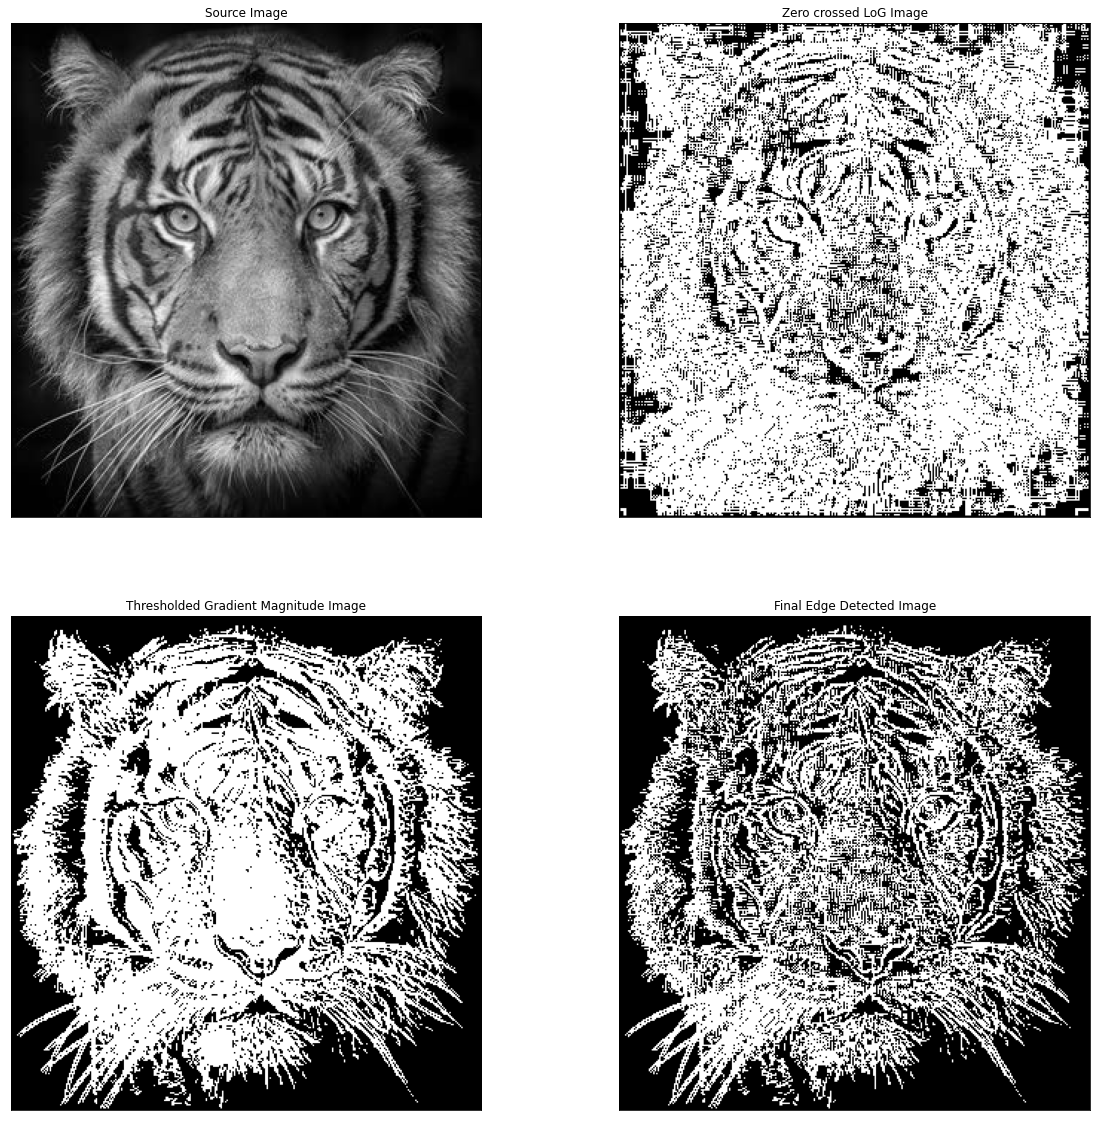

(333, 317)

In [10]:
def Laplacian_Edge_Detection(image, thresh=127, verbose=False):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 1. call to generate log applied on image
    laplaced_image = Laplacian_(image)
    
    # 2. apply zero crossing finder over the log image
    zero_crossed_binary_image = zero_crossing_finder(laplaced_image)
    
    # 3. in addition, find the gradient magnitude of each pixels
    mag_of_grad_image = Gradient_Magnitude(image)  
    
    # 4. apply thresholding on gradient magnitude of the image
    thresholded_mag_of_grad_image = cv2.threshold(mag_of_grad_image, thresh, 1, cv2.THRESH_BINARY)[1]
    
    # 5. use thresholded gradient magnitude image to post process (remove spurious patches) 
    # in laplacian of gaussian image zero crossed output image
    output_image = zero_crossed_binary_image * thresholded_mag_of_grad_image
    
    if verbose:
        
        plt.figure(figsize=(20, 20))
        
        plt.subplot(221)
        plt.imshow( image, cmap='gray')
        plt.title('Source Image'), plt.xticks([]), plt.yticks([])

        plt.subplot(222)
        plt.imshow( zero_crossed_binary_image, cmap='gray')
        plt.title('Zero crossed LoG Image'), plt.xticks([]), plt.yticks([])
        
        plt.subplot(223)
        plt.imshow( thresholded_mag_of_grad_image, cmap='gray')
        plt.title('Thresholded Gradient Magnitude Image'), plt.xticks([]), plt.yticks([])
        
        plt.subplot(224)
        plt.imshow( output_image, cmap='gray')
        plt.title('Final Edge Detected Image'), plt.xticks([]), plt.yticks([])
        
        plt.show()
    
    return output_image
    
    
final_output_image = Laplacian_Edge_Detection(img2_gray, 127, True)
final_output_image.shape